# ERO2 : Un petit TP

Ce document est à compléter, il sert d'évaluation sommative pour la première itération du cours d'ERO2. Merci de formuler vos questions sur le forum moodle prévu à cet effet.

In [49]:
import numpy as np
import pandas as pd

In [50]:
import matplotlib.pyplot as plt

## *Given Files*

Cette section regroupe les éléments déjà préalablement à votre disposition, vous êtes libres de vous en servir pour répondre aux différentes questions du TP.

In [51]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)): #here this is fifo, lambda x:-1 would be lifo
        self.size = size
        self.next = policy
        self.queue = []
        
    def populate(self, queue):
        if self.size is not None and len(queue) > self.size:
            print(f"Error: The size of the input queue is larger than the maximum size {self.size}.")
            return
        self.queue = queue
        
    def add(self, item):
        if self.size is None or len(self.queue) < self.size:
            self.queue.append(item)
            return True
        else:
            print("Error: The queue is full. Cannot add more items.")
            return False
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None

        if -len(self.queue) <= pop_ix < len(self.queue) : # Here there was a mistake, it's "<=" not "<"
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val
    def is_empty(self):
        return len(self.queue) == 0

In [52]:
#Since apparently there are issues in the code I will need to thoroughly test everything


def test_Wline():

    # Test FIFO behavior
    queue = Wline(size=3, policy=(lambda x: 0))
    queue.populate([1, 2, 3])
    assert queue.pop() == 1, "Error in test_Wline: FIFO behavior not working correctly."
    assert queue.pop() == 2, "Error in test_Wline: FIFO behavior not working correctly."
    assert queue.pop() == 3, "Error in test_Wline: FIFO behavior not working correctly."
    
    # Test LIFO behavior
    queue = Wline(size=3, policy=(lambda x: -1))
    queue.populate([1, 2, 3])
    assert queue.pop() == 3, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == 2, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == 1, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == None

    # Test size limit
    queue = Wline(size=3)
    queue.populate([1, 2, 3, 4])  # This should print an error message
    queue.populate([1, 2, 3])
    queue.add(4)  # This should also print an error message
    assert len(queue.queue) == 3, "Error in test_Wline: Size limit not working correctly."
    
    print("All tests passed successfully.")
    
# Run the tests
test_Wline()


Error: The size of the input queue is larger than the maximum size 3.
Error: The queue is full. Cannot add more items.
All tests passed successfully.


In [85]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [123]:
class QS():
    
    def __init__(self, arval_dist, srv_dist, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_dist = arval_dist
        self.srv_dist = srv_dist
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_dist(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        #print("arrival times :", tops['t_arval_queue'])
        
       # t_interarvals = self.srv_dist(size=(self.test_z))
        # Call the lambda function and store its output in x
       # print(t_interarvals)  # Print the value of x

        
    def run(self):

        # Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        processing_times = inservice.dist(size=(self.test_z))

        # Initializing arrival queue
        # Get the arrival times from the tops DataFrame
        arrival_times = tops['t_arval_queue'].values

        # wline.queue = list(tops.loc[:self.queue_z].index)
        wline.queue = list(tops.loc[0:0].index)  # Add the first agent to the waiting line
        # Initializing upcomgin theoretical arrival
        buffer_ix = 1
        current_time = arrival_times[0]

        print(current_time)

        while buffer_ix < self.test_z:
            _next = wline.pop()
            if _next is not None:  # Waiting line is not empty
                print(f"_next : {_next}")
                # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

                # Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

                # Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)

                # Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next

                if dept_ag is not None:
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                        # Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

                # Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
                current_time = tops.loc[_next, 't_depart_sys']

            else:
                current_time = arrival_times[buffer_ix]  # Get next arrival time, in case we don't get any clients by the time we are done processing current client


            while buffer_ix < self.test_z and arrival_times[buffer_ix] <= current_time:
                in_system = ((tops['t_depart_sys'] > current_time) | (tops.index.isin(wline.queue)) | (tops.index == _next)).sum()
                if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                    tops.loc[buffer_ix, 't_depart_sys'] = -1
                else:
                    wline.add(buffer_ix)
                buffer_ix += 1

            #buffer_ix += 1
            if (_next != None):
                current_time = tops.loc[_next, 't_depart_sys']
            print("Current Time: ", current_time)
            print("Current Queue:", wline.queue)

            # ok so in lifo I noticed that the first length - 1 elements don't ever get processed
            # because our server is too slow so once the buffer_ix gets exceeded, it cuts everything off.
            # I still want to process the queue
        while not wline.is_empty():
            """
            this loop is to finish processing the queue, otherwise the stats are completely off since those agents that have
            been waiting this entire time don't ever get accounted in our dataframe
            """
            _next = wline.pop()
            print(f"_next : {_next}")
            # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

            # Update server arrival time as if no waiting was needed
            tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

            # Find next available server
            srv_ix, dept_ag = inservice.leaving(tops)

            # Fill available server with corresponding next agent in waiting line
            inservice.server[srv_ix] = _next

            if dept_ag is not None:
                if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                    # Update server arrival time in case arrival is before system departure
                    tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

            # Update system departure time
            tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
            current_time = tops.loc[_next, 't_depart_sys']
            print("Current Time: ", current_time)
            print("Current Queue:", wline.queue)

                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
        
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)
        
        # Calculate longest wait time
        longest_wait_time = tops['t_waiting'].max()
        
        #Caculate the standard deviation
        wait_time_std = tops['t_waiting'].std()
        
        
        stats.loc['longest_wait_time'] = longest_wait_time
        stats.loc['wait_time_std'] = wait_time_std
        return process, stats

# Question 1

1. Comparer les comportements de files M/M/1/k et M/M/1/k/LIFO au regard des métriques qui vous semblent pertinentes. Appuyez vos conclusions de simulations et contextualisez vos choix.
2. Vos conclusions changent-elles dans le cas des M/M/1 et M/M/1/LIFO ?

## Work done

Run function had to be completely redone to do LIFO. Now I have a queue that isn´t fixed to a size 1 but actually the size of the queue and fills up accordingly. This allows us to use LIFO properly. I also added a system that fills the queue based on the current time. The current time is updated at each important event (departure time or arrival time if queue is empty).
I also noticed that the whole bufferx loop was fine for FIFO but for LIFO left some discrepencies in the stats because the loop would end while the queue was full which mean the waiting time for the first elements of the queue (which are very high) were never considered. So once by bufferx exceeds our test size then I process the whole queue.

Then there were a lot of issues with rng, because we had different samples between our fifo and lifo, it made for a poor comparison, we don´t know if the randomness was causing the differences or the different structures were causing the differences.
So I had to set the sample sizes like the arrival times to be identical between the fifo and lifo instance, also because different queue systems end up accepting different agents, I just set all of our srv dist to the same value so that doesn´t cause different of samplings of our srv_dist. 

In [164]:
def simulate(srv_nb, queue_size, test_size, seed, arrival_speed: float, srv_speed: float):
    rng = np.random.default_rng(seed=seed)
    srv_nb = srv_nb
    arval_dist = lambda size : rng.exponential(arrival_speed, size=size)
    #srv_dist = rng.exponential(srv_speed, size=size)
    
    srv_dist = lambda size : [srv_speed] * size 
    fifo_policy = lambda x : 0
    lifo_policy = lambda x : (-1)
    #define the population size
    test_size = test_size
    queue_size = queue_size

    # Generate the same random samples for both policies
    arival_dist_samples = arval_dist(size=test_size)
    srv_dist_samples = srv_dist(size=test_size)
    # Create instances of QS with the same arrival and service times
    mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
    mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)
    #define the population size
    test_size = test_size
    queue_size = queue_size

    # Generate the same random samples for both policies
    arival_dist_samples = arval_dist(size=test_size)
    srv_dist_samples = srv_dist(size=test_size)
    
    # Create instances of QS with the same arrival and service times
    mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
    mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)

    mm1_fifo.pretreat()
    mm1_lifo.pretreat()
    
    mm1_fifo.run()
    mm1_lifo.run()
    
    mm1_fifo.posttreat()
    mm1_lifo.posttreat()
    
    mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
    mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()
    
    mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

In [165]:
rng = np.random.default_rng(seed=42)

In [168]:
srv_nb = 1
arval_dist = lambda size : rng.exponential(1./60, size=size)
#srv_dist = lambda size : [1./100] * size # rng.exponential(1./4., size=size)
srv_dist = lambda size: rng.exponential(1./40, size=size)

fifo_policy = lambda x : 0
lifo_policy = lambda x : (-1)

I noticed that the random distribution for fifo and lifo generated different samples, it's good that they are random so that we can compare many fifos and many lifos but when comparing the 2 they should be running on the same set of samples.

In [169]:
#define the population size
test_size = 1000
queue_size = 10

# Generate the same random samples for both policies
arival_dist_samples = arval_dist(size=test_size)
srv_dist_samples = srv_dist(size=test_size)


In [170]:
# Create instances of QS with the same arrival and service times
mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)

In [171]:
mm1_fifo.pretreat()
mm1_lifo.pretreat()

In [172]:
mm1_fifo.run()
mm1_lifo.run()

0.020995811401586403
_next : 0
Current Time:  0.08661411463509833
Current Queue: [1, 2, 3, 4]
_next : 1
Current Time:  0.12414021195397612
Current Queue: [2, 3, 4, 5]
_next : 2
Current Time:  0.14917358499936653
Current Queue: [3, 4, 5]
_next : 3
Current Time:  0.18383123072217486
Current Queue: [4, 5, 6, 7, 8, 9]
_next : 4
Current Time:  0.19745673363765667
Current Queue: [5, 6, 7, 8, 9, 10]
_next : 5
Current Time:  0.21094866188446693
Current Queue: [6, 7, 8, 9, 10, 11, 12]
_next : 6
Current Time:  0.2146936482063675
Current Queue: [7, 8, 9, 10, 11, 12]
_next : 7
Current Time:  0.2268440273656987
Current Queue: [8, 9, 10, 11, 12, 13]
_next : 8
Current Time:  0.24660216858392497
Current Queue: [9, 10, 11, 12, 13]
_next : 9
Current Time:  0.2573253675781756
Current Queue: [10, 11, 12, 13]
_next : 10
Current Time:  0.2589520918412228
Current Queue: [11, 12, 13]
_next : 11
Current Time:  0.26009301774599874
Current Queue: [12, 13]
_next : 12
Current Time:  0.2690216515056305
Current Queu

Current Time:  4.190922420759404
Current Queue: [246, 247, 248, 249, 250, 251, 252]
_next : 246
Current Time:  4.276615760952098
Current Queue: [247, 248, 249, 250, 251, 252, 253, 254, 255, 256]
_next : 247
Current Time:  4.342717236440587
Current Queue: [248, 249, 250, 251, 252, 253, 254, 255, 256, 261]
_next : 248
Current Time:  4.354766554537769
Current Queue: [249, 250, 251, 252, 253, 254, 255, 256, 261]
_next : 249
Current Time:  4.361975438969098
Current Queue: [250, 251, 252, 253, 254, 255, 256, 261, 263]
_next : 250
Current Time:  4.555327903873634
Current Queue: [251, 252, 253, 254, 255, 256, 261, 263, 264, 265]
_next : 251
Current Time:  4.558263360607949
Current Queue: [252, 253, 254, 255, 256, 261, 263, 264, 265]
_next : 252
Current Time:  4.58645170610497
Current Queue: [253, 254, 255, 256, 261, 263, 264, 265, 280]
_next : 253
Current Time:  4.628615959722673
Current Queue: [254, 255, 256, 261, 263, 264, 265, 280, 281, 282]
_next : 254
Current Time:  4.629109616208763
Curr

Current Time:  8.861159855374634
Current Queue: [522]
_next : 522
Current Time:  8.863737064582727
Current Queue: []
Current Time:  8.88222624103199
Current Queue: [523]
_next : 523
Current Time:  8.888230300589656
Current Queue: []
Current Time:  8.925407232985199
Current Queue: [524]
_next : 524
Current Time:  8.937183349892793
Current Queue: [525]
_next : 525
Current Time:  8.959201933649037
Current Queue: [526, 527]
_next : 526
Current Time:  9.009167937760344
Current Queue: [527, 528]
_next : 527
Current Time:  9.010217737232574
Current Queue: [528]
_next : 528
Current Time:  9.015154570006727
Current Queue: []
Current Time:  9.028637972501436
Current Queue: [529]
_next : 529
Current Time:  9.03562844083064
Current Queue: [530]
_next : 530
Current Time:  9.077452272843447
Current Queue: [531]
_next : 531
Current Time:  9.09558445833952
Current Queue: [532]
_next : 532
Current Time:  9.104325803202284
Current Queue: [533]
_next : 533
Current Time:  9.11654496286153
Current Queue: [

Current Time:  12.5870431474694
Current Queue: [749, 750, 751, 752, 753]
_next : 749
Current Time:  12.63264531335936
Current Queue: [750, 751, 752, 753, 754]
_next : 750
Current Time:  12.659029168953948
Current Queue: [751, 752, 753, 754, 755]
_next : 751
Current Time:  12.664757829936486
Current Queue: [752, 753, 754, 755]
_next : 752
Current Time:  12.691634809676518
Current Queue: [753, 754, 755, 756, 757]
_next : 753
Current Time:  12.722982276656687
Current Queue: [754, 755, 756, 757, 758]
_next : 754
Current Time:  12.76361135743226
Current Queue: [755, 756, 757, 758, 759, 760, 761, 762, 763]
_next : 755
Current Time:  12.776251366804926
Current Queue: [756, 757, 758, 759, 760, 761, 762, 763]
_next : 756
Current Time:  12.790645348060282
Current Queue: [757, 758, 759, 760, 761, 762, 763, 764]
_next : 757
Current Time:  12.80954790674513
Current Queue: [758, 759, 760, 761, 762, 763, 764, 765]
_next : 758
Current Time:  12.826632696086929
Current Queue: [759, 760, 761, 762, 763, 

Current Time:  16.693820501901094
Current Queue: [982, 983, 984, 985, 986, 987, 988, 989, 990, 992]
_next : 982
Current Time:  16.806615719458108
Current Queue: [983, 984, 985, 986, 987, 988, 989, 990, 992, 999]
_next : 983
Current Time:  16.81825351050546
Current Queue: [984, 985, 986, 987, 988, 989, 990, 992, 999]
_next : 984
Current Time:  16.834854569260038
Current Queue: [985, 986, 987, 988, 989, 990, 992, 999]
_next : 985
Current Time:  16.873082391923376
Current Queue: [986, 987, 988, 989, 990, 992, 999]
_next : 986
Current Time:  16.88330190326637
Current Queue: [987, 988, 989, 990, 992, 999]
_next : 987
Current Time:  16.9473006450302
Current Queue: [988, 989, 990, 992, 999]
_next : 988
Current Time:  16.963336636101715
Current Queue: [989, 990, 992, 999]
_next : 989
Current Time:  16.974498419063377
Current Queue: [990, 992, 999]
_next : 990
Current Time:  16.98795361132636
Current Queue: [992, 999]
_next : 992
Current Time:  16.997031199771662
Current Queue: [999]
_next : 99

Current Time:  4.485541747585101
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244, 264, 268]
_next : 268
Current Time:  4.491806754755902
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244, 264, 274]
_next : 274
Current Time:  4.49238226027181
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244, 264]
_next : 264
Current Time:  4.523114915680985
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244, 275, 276]
_next : 276
Current Time:  4.533618067116437
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244, 275, 277]
_next : 277
Current Time:  4.536695223961649
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244, 275, 279]
_next : 279
Current Time:  4.54346508593601
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244, 275]
_next : 275
Current Time:  4.5502623134494815
Current Queue: [15, 104, 109, 177, 238, 239, 241, 244]
_next : 244
Current Time:  4.565937555313831
Current Queue: [15, 104, 109, 177, 238, 239, 241]
_next : 241
Current Time:  4.571596473689089
Current Queue

Current Time:  9.028637972501436
Current Queue: [529]
_next : 529
Current Time:  9.03562844083064
Current Queue: [530]
_next : 530
Current Time:  9.077452272843447
Current Queue: [531]
_next : 531
Current Time:  9.09558445833952
Current Queue: [532]
_next : 532
Current Time:  9.104325803202284
Current Queue: [533]
_next : 533
Current Time:  9.11654496286153
Current Queue: [534, 535, 536]
_next : 536
Current Time:  9.159106794630608
Current Queue: [534, 535, 537, 538, 539, 540, 541]
_next : 541
Current Time:  9.250913721640842
Current Queue: [534, 535, 537, 538, 539, 540, 542, 543, 544, 545]
_next : 545
Current Time:  9.264668656740213
Current Queue: [534, 535, 537, 538, 539, 540, 542, 543, 544, 549]
_next : 549
Current Time:  9.289399338903513
Current Queue: [534, 535, 537, 538, 539, 540, 542, 543, 544, 550]
_next : 550
Current Time:  9.308395093123789
Current Queue: [534, 535, 537, 538, 539, 540, 542, 543, 544, 551]
_next : 551
Current Time:  9.324676167241797
Current Queue: [534, 535

Current Time:  13.156800548862893
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 780, 790]
_next : 790
Current Time:  13.188313005497019
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 780, 791]
_next : 791
Current Time:  13.205820818627066
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 780, 792]
_next : 792
Current Time:  13.242539850080354
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 780, 794]
_next : 794
Current Time:  13.243453086533716
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 780]
_next : 780
Current Time:  13.261565395652955
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 797]
_next : 797
Current Time:  13.269611905347848
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 798]
_next : 798
Current Time:  13.290815792643231
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769, 799]
_next : 799
Current Time:  13.297923745233247
Current Queue: [534, 535, 739, 740, 742, 743, 766, 769]
_next : 769
Current Time:  13.3110

In [173]:
mm1_fifo.posttreat()
mm1_lifo.posttreat()

In [174]:
mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()

In [175]:
mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

,run value_fifo,run value_lifo
mean_sojourn_time,0.220455,0.233169
mean_waiting_time,0.195909,0.207768
mean_service_time,0.024546,0.025401
waiting_proportion,0.991292,0.993976
blocked_proportion,0.311,0.336
servers_max_usage,0.993497,0.995498
longest_wait_time,0.468469,8.57608
wait_time_std,0.119397,0.642432


As can be denoted from the results, the mean_service_time and mean_sojourn_time are exact same if you don´t introduce any randomness.

We find that the average wait time and sojourn time is **identical**.
The service time isn´t really pertinent as it as to do with the srv_dist.
    We can also see that the standard deviation and longest wait time are much higher for lifo than for fifo. This makes a lot of sense since lifo will make the first agent wait the entire queue as the queue is building, so the whole time the queue is open + the time it takes to process all other agents in the queue.
    
I'm sure you could achieve similar results without removing randomness by having a very large sample size, like a large test size because of the law of large numbers. But why do this when we can simply test on the same sample sets.

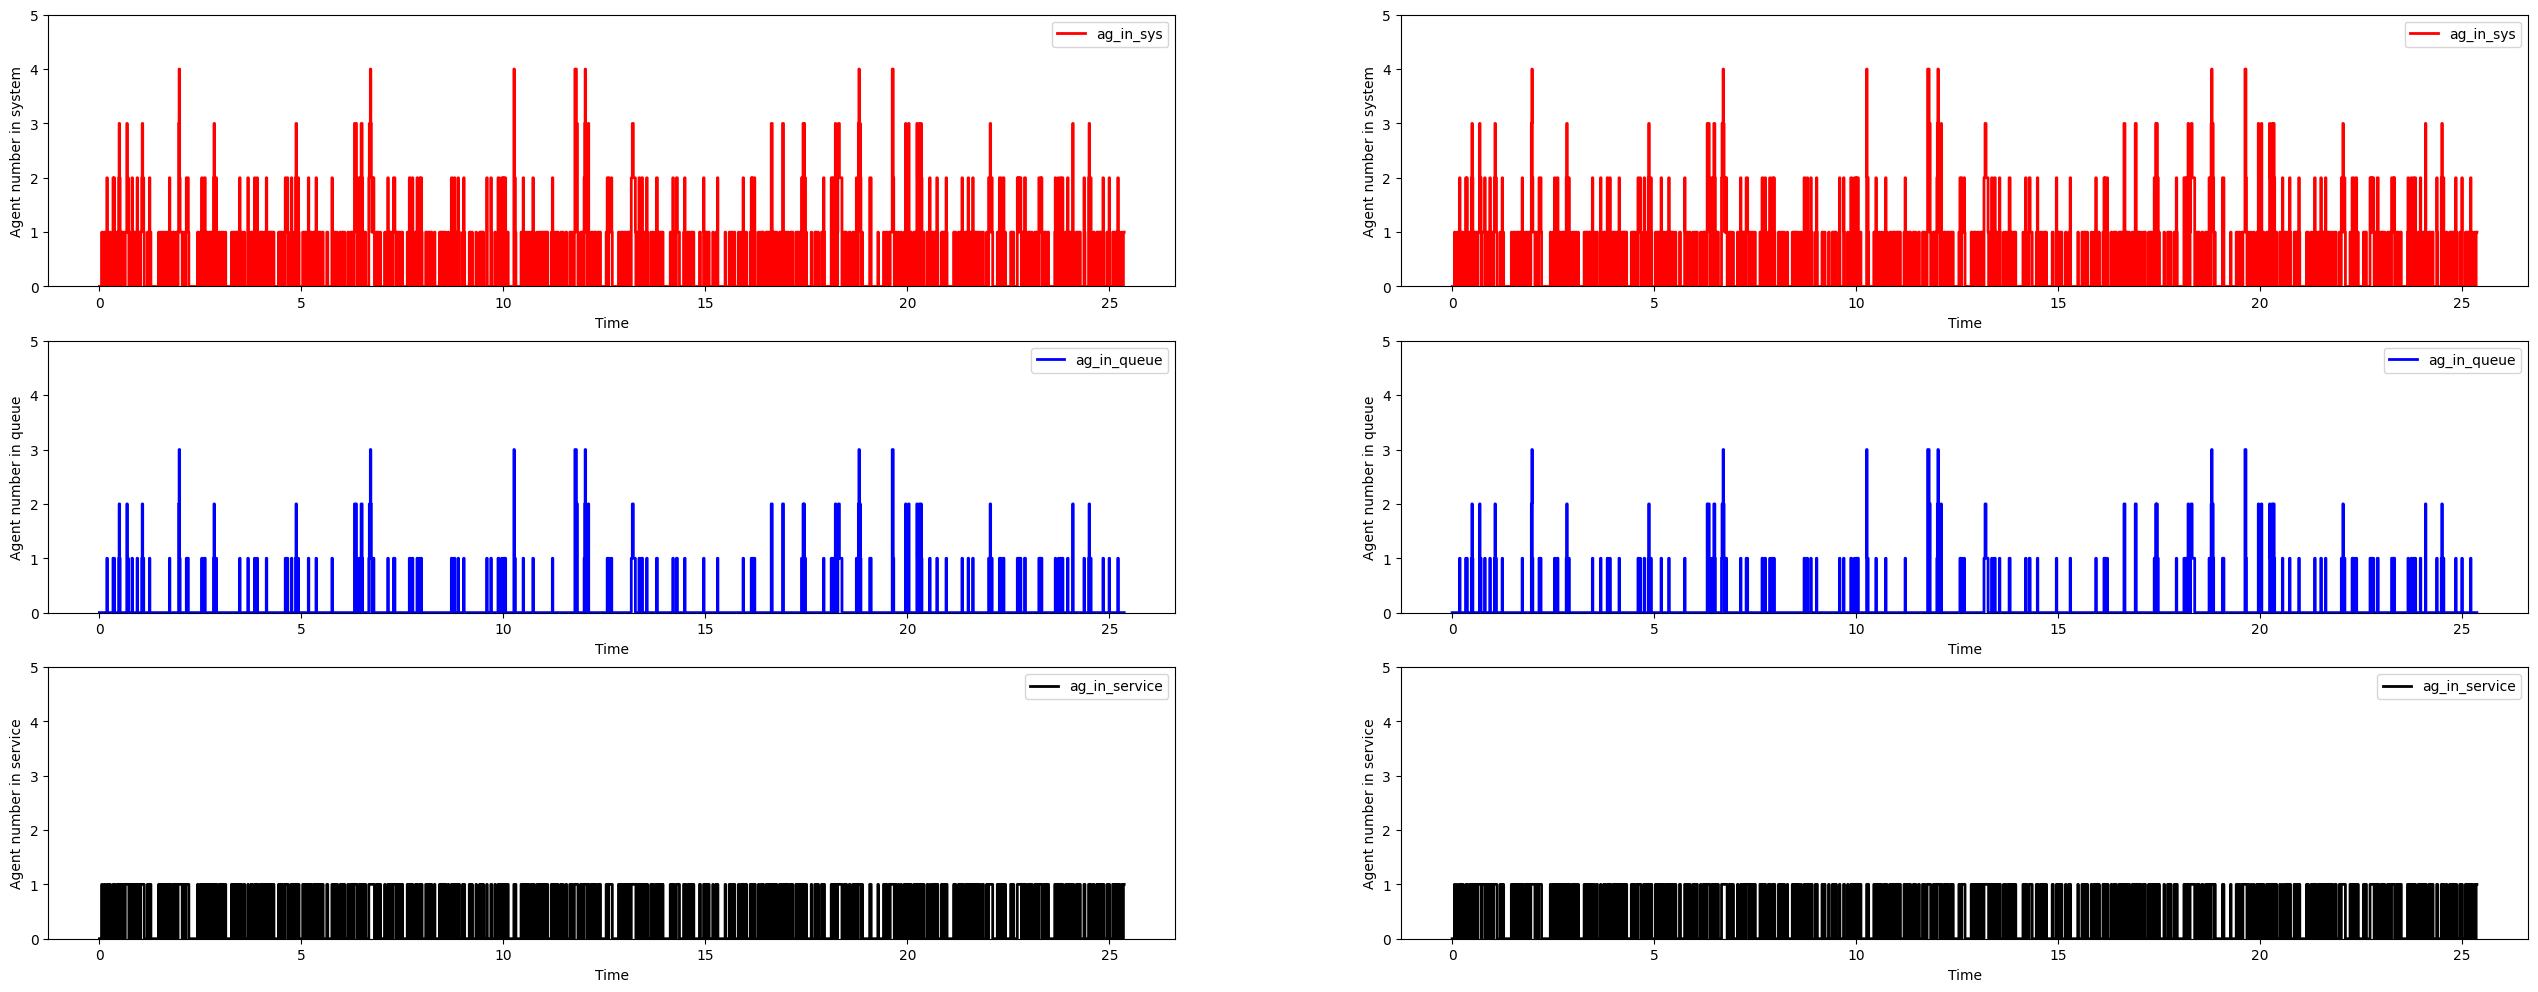

In [136]:
fig, axes = plt.subplots(3, 2, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_fifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench['ag_in_sys']+1)])
    
    mm1_lifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench['ag_in_sys']+1)])

# Question 2

On suppose avoir à diposition $5$ serveurs $s_1$, $\ldots$, $s_5$ et $3$ files d'arrivées *FIFO* $f_1$, $f_1$, $f_3$ de tailles respectives $z_1$, $z_2$, $z_3$. Les temps de services de nos serveurs sont respectivements donnés par des lois exponentielles paramètres $\mu_1$, $\ldots$, $\mu_5$, ordonnés par ordre croissant.  

Une population d'agents s'adresse à notre service, déployé identitiquement sur chaque serveur. On constate que cette population est décomposée en $5$ sous-populations $A_1$, $\ldots$, $A_5$ dont les processus d'arrivées sont respectivement d'intensités $\lambda_1$, $\ldots$, $\lambda_5$, ordonnés par ordre croissants. Les tailles respectives de chacune des populations sont $a_1$, $\ldots$, $a_5$ ; elles vérifient les relations $a_i > 2\max\{z_1, z_2, z_3\}$ pour tout $1 \leq i \leq 3$.   

1. Simuler un système d'attente qui permet de répondre aux besoins de services.
2. Comparer un minimum de trois architectures possibles, au regard des ressources à disposition, pour répondre aux besoins de services. Vous êtes attendus sur des simulations appuyants vos propos.
3. Quelles modifications apporteriez-vous sur votre proposition si l'on introduit une fonction de dissatisfaction des agents donnée par $ b_1 + 2 b_2 + \cdots 5 b_5$, où $b_i$ correspond au nombre d'agents de la populations $A_i$ qui n'ont pas pu avoir accès au système ?

Vous êtes autorisé d'effectuer des hypothèses simplificatrices dans votre travail. Attention à ce qu'elles ne soient pas *trop* simplificatrices.